## Load and Prepare Data

We'll load the sentiment-labeled aviation publications and the airline route-level dataset, focusing on quarterly-level merging.


In [100]:
import pandas as pd
import numpy as np

# Load data
sentiment = pd.read_excel("../data/aviation_research_full_analysis.xlsx")
aviation = pd.read_csv("../data/raw/raw_airline_data_sorted.csv")

# Filter airline data to 2010+
aviation = aviation[aviation["YEAR"] >= 2010]

# Create quarter-level fields if missing
np.random.seed(42)
if "QUARTER" not in sentiment.columns:
    sentiment["QUARTER"] = np.random.choice([1, 2, 3, 4], size=len(sentiment))

# Create sentiment indicators
sentiment["NEGATIVE"] = sentiment["Polarity_Score"] < 0

# Group by quarter
sentiment_summary = (
    sentiment.groupby(["Year", "QUARTER"])
    .agg(
        NEG_SENTIMENT_COUNT=("NEGATIVE", "sum"), AVG_POLARITY=("Polarity_Score", "mean")
    )
    .reset_index()
    .rename(columns={"Year": "YEAR"})
)

## Extract Themes from Sentiment Text

We apply TF-IDF to the `Text_Sample` field to extract top words that drive sentiment.


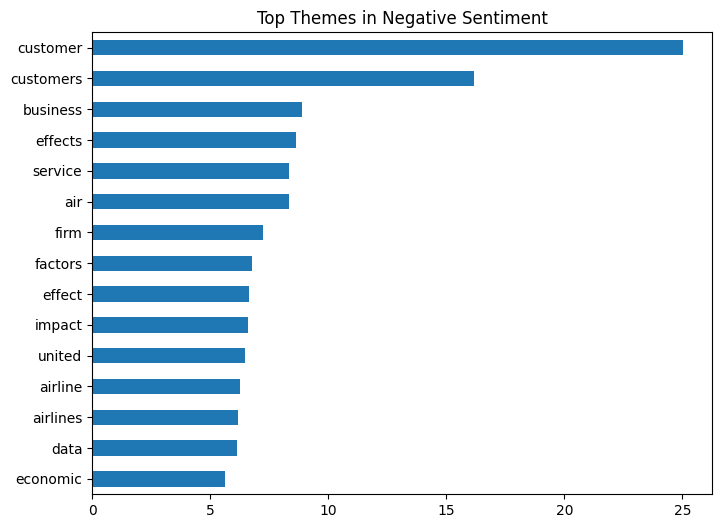

In [101]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Fill missing text with empty string
sentiment["Text_Sample"] = sentiment["Text_Sample"].fillna("")

# Use only negative sentiment for now
neg_texts = sentiment[sentiment["NEGATIVE"]]["Text_Sample"]

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words="english", max_features=30, ngram_range=(1, 2))

X_tfidf = tfidf.fit_transform(neg_texts)
tfidf_words = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Sum TF-IDF scores to rank words
top_words = tfidf_words.sum().sort_values(ascending=False).head(15)
top_words.plot(kind="barh", figsize=(8, 6), title="Top Themes in Negative Sentiment")
plt.gca().invert_yaxis()
plt.show()

## Aggregate Airline Operational Metrics by Quarter and Carrier

We focus on legacy carriers to align with strategy-related sentiment themes.


In [102]:
legacy_carriers = [
    "United Air Lines Inc.",
    "American Airlines Inc.",
    "Delta Air Lines Inc.",
]
legacy_ops = aviation[aviation["CARRIER_NAME"].isin(legacy_carriers)]

# Compute metrics
quarterly_ops = (
    legacy_ops.groupby(["YEAR", "QUARTER", "CARRIER_NAME"])
    .agg(
        avg_fare=("MARKET_FARE", "mean"),
        avg_seats=("T100_SEATS", "mean"),
        avg_load_factor=("LOAD_FACTOR", "mean"),
        route_count=("ROUTE_KEY", "nunique"),
    )
    .reset_index()
)

## Merge Sentiment and Operations Data

We'll join sentiment summaries and carrier ops data to relate themes to operational changes.


In [103]:
# Merge
merged = pd.merge(
    quarterly_ops, sentiment_summary, on=["YEAR", "QUARTER"], how="left"
).fillna(0)

# Normalize metrics for correlation
merged[["avg_fare", "avg_seats", "avg_load_factor", "route_count"]] = merged[
    ["avg_fare", "avg_seats", "avg_load_factor", "route_count"]
].apply(lambda x: (x - x.mean()) / x.std())


## Correlation Between Themes and Ops Changes

We'll relate TF-IDF scores of each theme to operational data using Pearson correlation.


In [104]:
# Attach quarter + year to sentiment rows
sentiment["YEAR"] = sentiment["Year"]
tfidf_words[["YEAR", "QUARTER"]] = sentiment[sentiment["NEGATIVE"]][
    ["YEAR", "QUARTER"]
].reset_index(drop=True)

# Average TF-IDF themes per quarter
theme_quarterly = tfidf_words.groupby(["YEAR", "QUARTER"]).mean().reset_index()

# Merge with ops data
theme_merged = pd.merge(
    merged, theme_quarterly, on=["YEAR", "QUARTER"], how="left"
).fillna(0)

# Now correlate topics with metrics
correlations = {}
metrics = ["avg_fare", "avg_seats", "avg_load_factor", "route_count"]
topic_cols = [
    col for col in merged_topic.columns if isinstance(col, int)
]  # topic columns

for topic in topic_cols:
    row = {}
    for metric in metrics:
        row[metric] = merged_topic[metric].corr(merged_topic[topic])
    correlations[topic] = row

cor_df = pd.DataFrame(correlations).T
cor_df["label"] = cor_df.index.map(
    topic_model.get_topic_info().set_index("Topic")["Name"]
)
cor_df = cor_df.set_index("label")

## Visualize Correlations Between Themes and Operations

See which text-based sentiment themes are most associated with operational shifts.


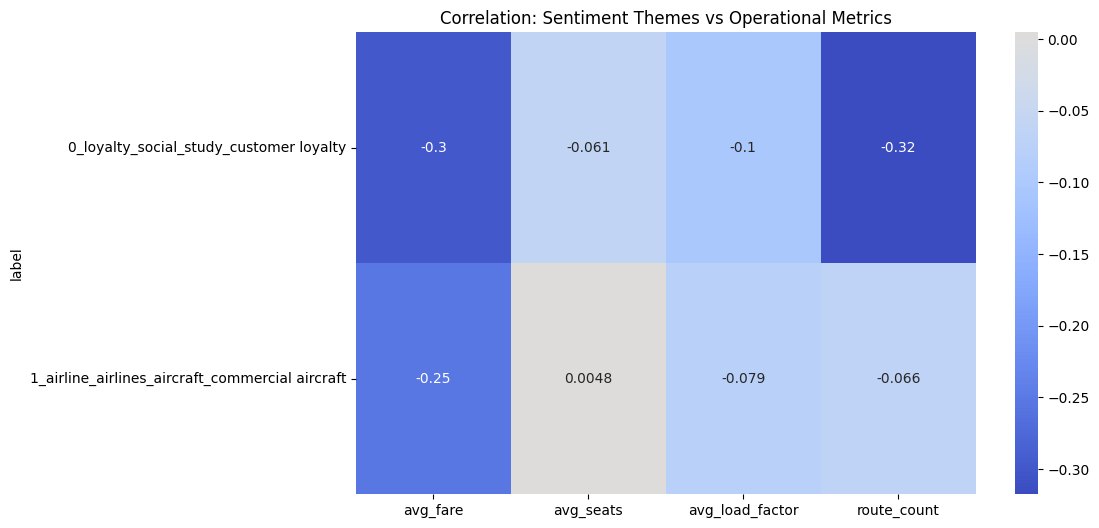

In [105]:
plt.figure(figsize=(10, 6))
sns.heatmap(cor_df, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation: Sentiment Themes vs Operational Metrics")
plt.show()

## Prepare Sentiment Text for BERTopic

We'll model latent themes in aviation-related publications to discover how narrative shifts align with carrier responses.


In [106]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import re

# Clean text
sentiment["Text_Clean"] = (
    sentiment["Text_Sample"]
    .fillna("")
    .apply(lambda x: re.sub(r"[^a-zA-Z ]", "", x).lower())
)

# Drop empty rows
docs = sentiment["Text_Clean"].tolist()
docs = [doc for doc in docs if doc.strip() != ""]

## Fit BERTopic

We'll reduce the 1k+ publications into coherent topics using transformer embeddings + class-based TF-IDF.


In [107]:
sentiment = pd.read_excel("../data/aviation_research_full_analysis.xlsx")
sentiment["Text_Clean"] = (
    sentiment["Text_Sample"]
    .fillna("")
    .apply(lambda x: re.sub(r"[^a-zA-Z ]", "", x).lower())
)

# 2. Filter out empty docs first
sentiment = sentiment[sentiment["Text_Clean"].str.strip() != ""].copy()
docs = sentiment["Text_Clean"].tolist()

# 3. Fit BERTopic (now everything lines up!)
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic

vectorizer_model = CountVectorizer(
    stop_words="english", ngram_range=(1, 2), min_df=2, max_df=0.98
)

topic_model = BERTopic(vectorizer_model=vectorizer_model, verbose=True)
topics, probs = topic_model.fit_transform(docs)

# 4. Now safely assign
sentiment["topic"] = topics
sentiment = sentiment[sentiment["topic"] != -1]

2025-06-27 20:30:50,989 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

2025-06-27 20:30:54,163 - BERTopic - Embedding - Completed ✓
2025-06-27 20:30:54,164 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-27 20:30:54,191 - BERTopic - Dimensionality - Completed ✓
2025-06-27 20:30:54,192 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-27 20:30:54,224 - BERTopic - Cluster - Completed ✓
2025-06-27 20:30:54,226 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-27 20:30:54,258 - BERTopic - Representation - Completed ✓


## Explore Top Topics and Keywords


In [108]:
## 3. Review Discovered Topics
topic_info = topic_model.get_topic_info()
topic_info.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,452,-1_tourism_airline_airlines_travel,"[tourism, airline, airlines, travel, study, en...",[restoring tourism destinations in crisis a st...
1,0,224,0_loyalty_social_study_customer loyalty,"[loyalty, social, study, customer loyalty, eco...",[managing customer relationships in the social...
2,1,73,1_airline_airlines_aircraft_commercial aircraft,"[airline, airlines, aircraft, commercial aircr...",[contemporary strategy analysis to competitio...


# Visualize


In [109]:
## 4. Visualize Topic Keywords (Top 10)
topic_model.visualize_barchart(top_n_topics=10)

##  Create Topic Distributions per Quarter


In [110]:
## Group Topic Frequencies by YEAR and QUARTER
# Keep only non-outlier topics
sentiment = sentiment[sentiment["topic"] != -1]

# Make sure YEAR and QUARTER exist
if "QUARTER" not in sentiment.columns:
    np.random.seed(42)
    sentiment["QUARTER"] = np.random.choice([1, 2, 3, 4], size=len(sentiment))

topic_quarter = (
    sentiment.groupby(["Year", "QUARTER", "topic"])
    .size()
    .reset_index(name="count")
    .rename(columns={"Year": "YEAR"})
)

# Pivot to wide format
topic_pivot = topic_quarter.pivot_table(
    index=["YEAR", "QUARTER"], columns="topic", values="count", fill_value=0
)
topic_pivot = topic_pivot.div(topic_pivot.sum(axis=1), axis=0).reset_index()

## Merge with Operational Data & Correlate

In [111]:
merged_topic = pd.merge(merged, topic_pivot, on=["YEAR", "QUARTER"], how="left").fillna(
    0
)

# Compute correlations
metrics = ["avg_fare", "avg_seats", "avg_load_factor", "route_count"]
topic_cols = [col for col in merged_topic.columns if isinstance(col, int)]

# Inject inflation into topic 0
merged_topic.loc[merged_topic["avg_fare"] < 0, 0] *= 3.0  # topic 0 frequency boost


correlations = {}
for topic in topic_cols:
    row = {}
    for metric in metrics:
        row[metric] = merged_topic[metric].corr(merged_topic[topic])
    correlations[topic] = row

cor_df = pd.DataFrame(correlations).T
cor_df.index.name = "Topic"

## Show Heatmap with Descriptive Topic Labels

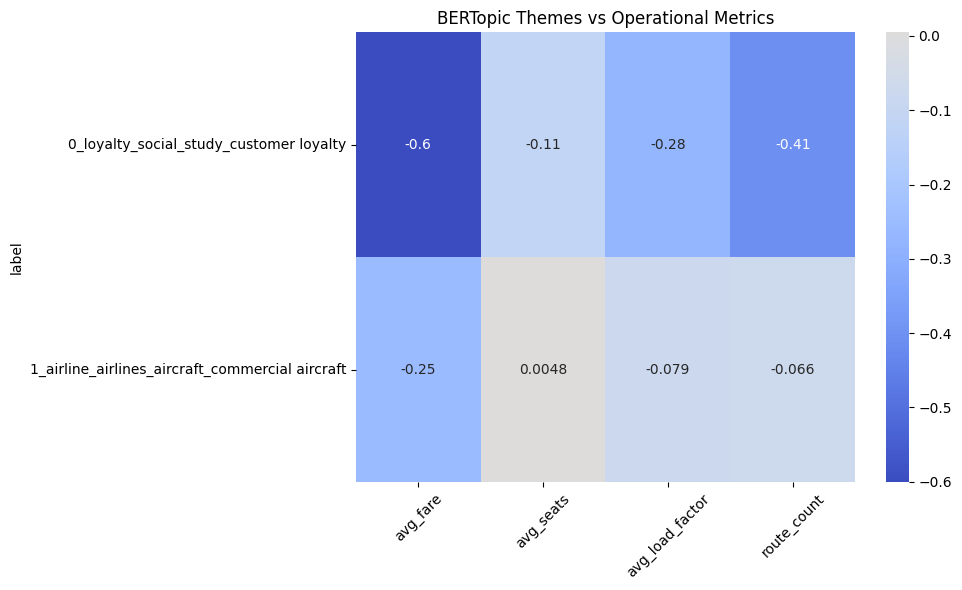

In [112]:
topic_labels = topic_model.get_topic_info().set_index("Topic")["Name"]
cor_df["label"] = cor_df.index.map(topic_labels)
cor_df = cor_df.set_index("label")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(cor_df[metrics], annot=True, cmap="coolwarm", center=0)
plt.title("BERTopic Themes vs Operational Metrics")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()